<a href="https://colab.research.google.com/github/ReynardAdimas/Asah/blob/main/Reynard_Adimas_Nabil_Template_Submission_Akhir_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Vegetable Image Dataset
- **Nama:** Reynard Adimas Nabil
- **Email:** m297d5y1692@student.devacademy.id
- **ID Dicoding:** M297D5Y1692

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [ ]:
!pip install -q kaggle
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable 

### Data Preprocessing

In [ ]:
import os
import shutil

train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"
validation_dir = "Vegetable Images/validation"

combined_dir = "Vegetable Images/dataset"

os.makedirs(combined_dir, exist_ok=True)

for category in os.listdir(train_dir):
  category_dir = os.path.join(train_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
  category_dir = os.path.join(test_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(validation_dir):
  category_dir = os.path.join(validation_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

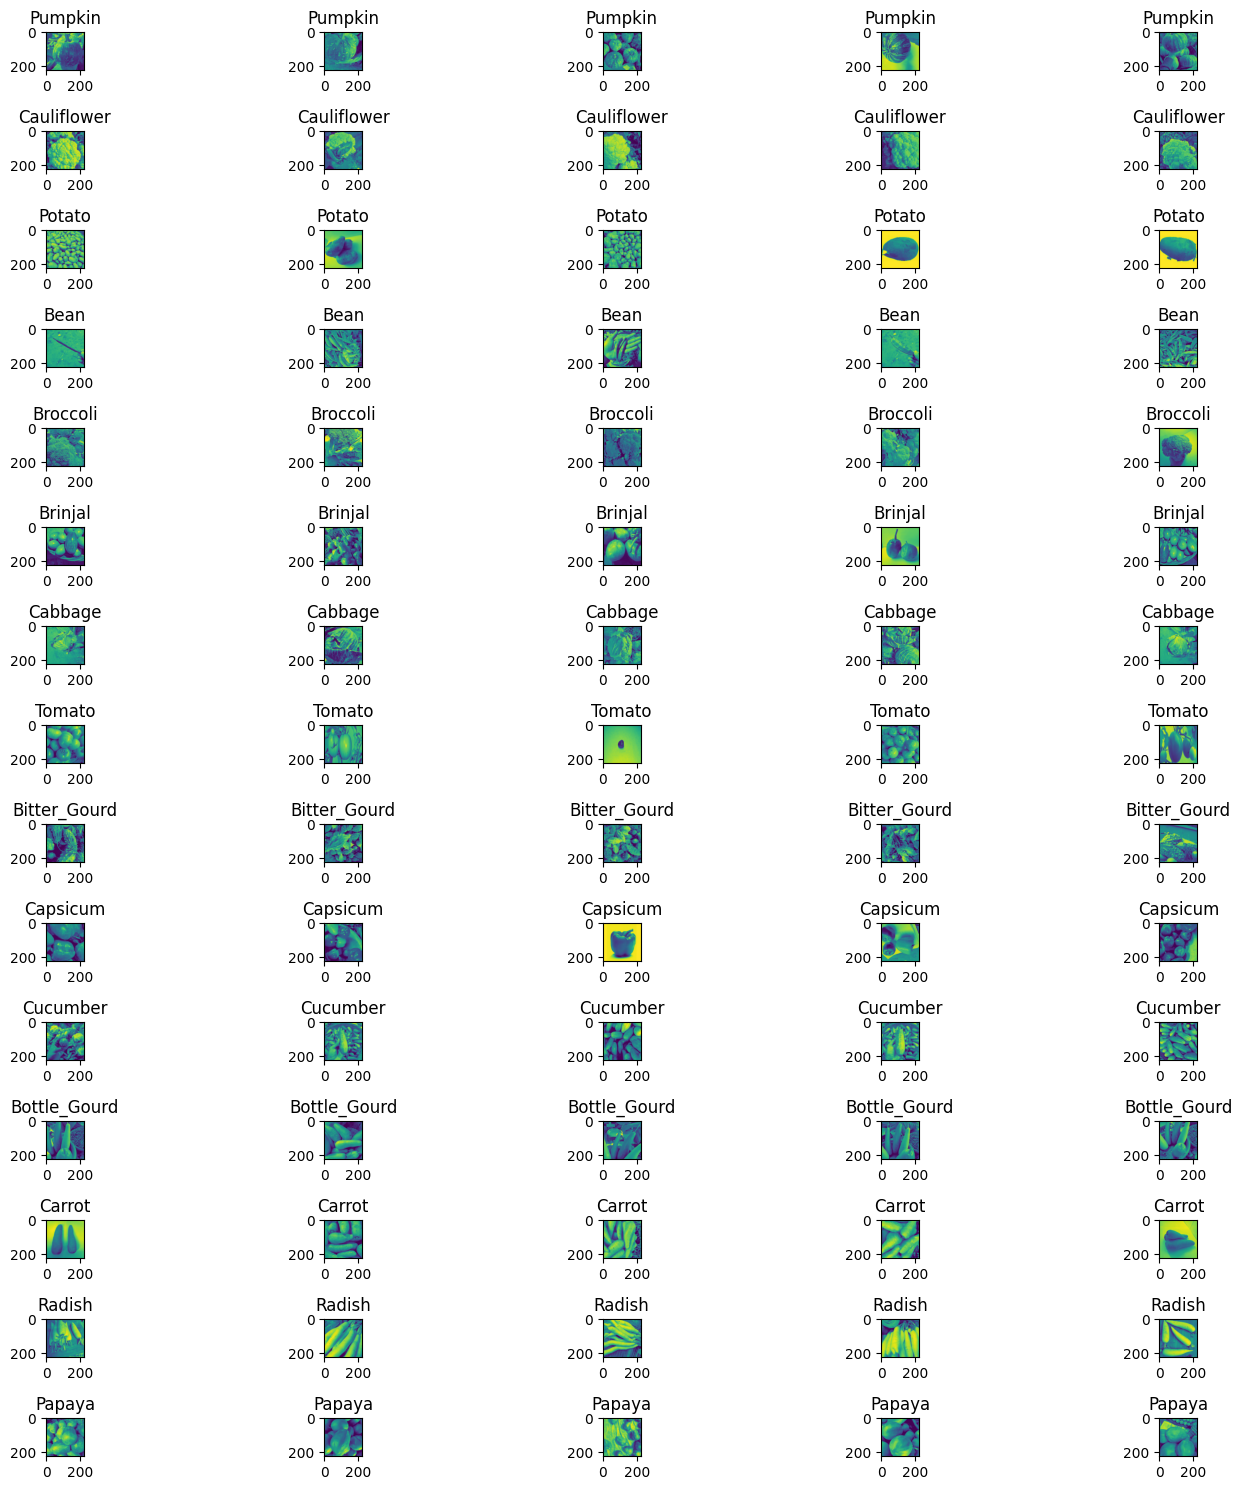

In [ ]:
# Dataset Checking
vegetable_image = {}

path = "Vegetable Images/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
  vegetable_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "Vegetable Images/dataset/"

fig, axes = plt.subplots(len(vegetable_image.keys()), 5, figsize=(15,15))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(vegetable_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert("L")
    axes[i, j].imshow(img)
    axes[i, j].set_title(class_name)



fig.tight_layout()

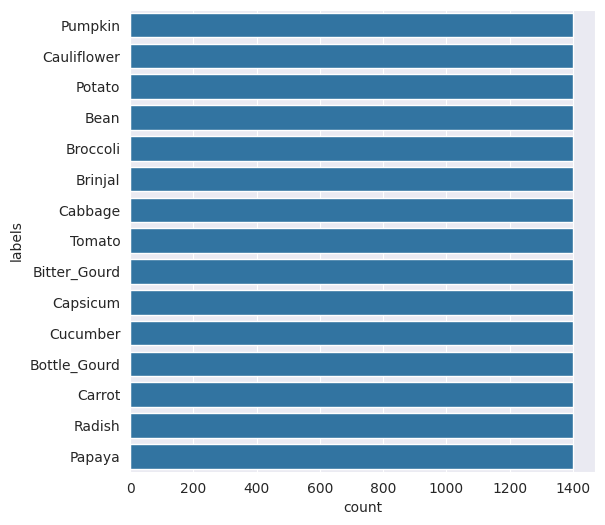

In [ ]:
# Plot Distribusi
vegetable_path = "Vegetable Images/dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(vegetable_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    k_size = random.choice([3,5,7])
    img = cv2.GaussianBlur(img, (k_size, k_size), 0)
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Vegetable Images/dataset/"
augmented_path = "Vegetable Images/augmented/"

if not os.path.exists(augmented_path):
  os.makedirs(augmented_path)

# The variable 'images' is not defined. It seems you intended to get a list of all image paths from the dataset.
# I will add a line to collect all image paths from 'images_path' into the 'images' list.
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Total Image: {len(images)}")

i = 1
images_to_generate = 2500
while i<= images_to_generate:
  image_path_select = random.choice(images)

  try:
    class_name = os.path.basename(os.path.dirname(image_path_select)) # Corrected to get class name from directory
    original_image = io.imread(image_path_select)

    if original_image.ndim < 3:
      continue

    transformed_image = original_image.copy()
    transformation_count = random.randint(1, len(transformations))

    n = 0
    while n < transformation_count:
      key = random.choice(list(transformations))

      transformed_image = transformations[key](transformed_image)
      n = n+1

    save_path = os.path.join(augmented_path, class_name)
    if not os.path.exists(save_path):
      os.makedirs(save_path)

    # Convert float image to uint8 for cv2.imwrite
    transformed_image = img_as_ubyte(transformed_image)
    # Check if the image is grayscale or color before converting
    if transformed_image.ndim == 3 and transformed_image.shape[-1] == 3:
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
    elif transformed_image.ndim == 2:
        transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_GRAY2BGR)

    new_image_name = f"aug_{i}.jpg"
    new_image_path = os.path.join(save_path, new_image_name)

    cv2.imwrite(new_image_path, transformed_image)

    if i%100 == 0:
      print(f"Berhasil generate {i} gambar")

    i = i+1
  except Exception as e:
    print(f"Error: {e}")


Output streaming akan dipotong hingga 5000 baris terakhir.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -1 and 1.
Error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Error: Images of type float must be between -1 and 1.
Error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'GaussianBlur'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Error: Images of type float must be between -1 and 1.
Error: Images of type float must be between -

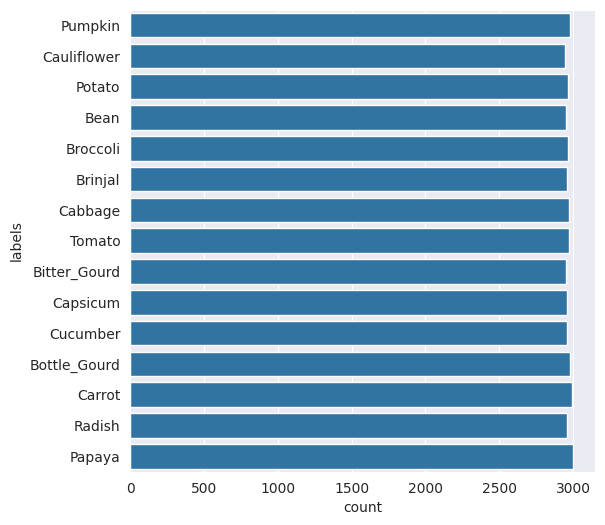

In [ ]:
img_path = "Vegetable Images/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(img_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, "file_name" : file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [ ]:
mypath = "Vegetable Images/"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({"path" : full_path, "file_name" : file_name, "labels":labels})
df.groupby(['labels']).size()



,0
labels,
Bean,2951
Bitter_Gourd,2952
Bottle_Gourd,2976
Brinjal,2961
Broccoli,2962
Cabbage,2971
Capsicum,2957
Carrot,2991
Cauliflower,2945


In [ ]:
X = df['path']
y = df['labels']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=420)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=420)

In [ ]:
df_tr = pd.DataFrame({"path":X_train, "labels":y_train, "set" : "train"})
df_val = pd.DataFrame({"path":X_val, "labels":y_val, "set" : "validation"})
df_test = pd.DataFrame({"path":X_test, "labels":y_test, "set" : "test"})

print('train size', len(df_tr))
print('validation size', len(df_val))
print('test size', len(df_test))

train size 35600
validation size 4450
test size 4450


In [ ]:
df_all = pd.concat([df_tr, df_val, df_test], ignore_index=True)

print(df_all.groupby(['set','labels']).size(),'\n')

print(df_all.sample(5))

set         labels      
test        Bean             308
            Bitter_Gourd     273
            Bottle_Gourd     288
            Brinjal          330
            Broccoli         283
            Cabbage          326
            Capsicum         277
            Carrot           306
            Cauliflower      314
            Cucumber         264
            Papaya           289
            Potato           302
            Pumpkin          326
            Radish           276
            Tomato           288
train       Bean            2343
            Bitter_Gourd    2368
            Bottle_Gourd    2395
            Brinjal         2353
            Broccoli        2385
            Cabbage         2362
            Capsicum        2385
            Carrot          2389
            Cauliflower     2335
            Cucumber        2401
            Papaya          2426
            Potato          2348
            Pumpkin         2345
            Radish          2402
            Tomato

In [ ]:
from tqdm.notebook import tqdm

df_all = pd.concat([df_tr, df_val, df_test], ignore_index=True)

dataset_final_path = "Dataset-Final"

for index, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):
  src = row['path']
  label_name = row['labels']
  split_type = row['set']
  dest_dir = os.path.join(dataset_final_path, split_type, label_name)
  if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

  file_name = os.path.basename(src)
  dest = os.path.join(dest_dir, file_name)

  if os.path.exists(src):
    if not os.path.exists(dest):
      shutil.copy2(src, dest)
  else:
    print(f"File tidak ditemukan di {src}")

print("\nProses penyalinan selesai")

  0%|          | 0/44500 [00:00<?, ?it/s]


Proses penyalinan selesai


##Image Data Generator

In [ ]:
import os

base_dir = "Dataset-Final"
TRAIN_DIR = os.path.join(base_dir, 'train')
VAL_DIR = os.path.join(base_dir, 'validation')
TEST_DIR = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 22112 images belonging to 15 classes.
Found 4234 images belonging to 15 classes.
Found 4231 images belonging to 15 classes.


## Modelling

In [ ]:
num_classes = train_generator.num_classes

model_1 = Sequential()

model_1.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150,150,3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2,2)))

model_1.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Flatten())
model_1.add(Dense(256, activation = 'relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dropout(0.3))
model_1.add(Dense(num_classes, activation='softmax'))
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print(model_1.summary())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,746,063 (40.99 MB)

 Trainable params: 10,745,615 (40.99 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [ ]:
from sklearn.utils import class_weight

train_labels = train_generator.classes
unique_classes = np.unique(train_labels)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=train_labels
)

class_weights_dict = dict(zip(unique_classes, class_weights))
print(f"Class Weight:{class_weights_dict}")

history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    class_weight=class_weights_dict,
    verbose=1
)

Class Weight:{np.int32(0): np.float64(1.0082991336069311), np.int32(1): np.float64(1.0034944406625823), np.int32(2): np.float64(0.986702365015618), np.int32(3): np.float64(1.0124542124542124), np.int32(4): np.float64(1.0048625312428994), np.int32(5): np.float64(1.0007694048427247), np.int32(6): np.float64(1.0055479763528876), np.int32(7): np.float64(0.9840676457498887), np.int32(8): np.float64(1.0159430277969217), np.int32(9): np.float64(1.0014492753623188), np.int32(10): np.float64(0.9749559082892416), np.int32(11): np.float64(1.0076099339257234), np.int32(12): np.float64(0.9980591288648161), np.int32(13): np.float64(0.9980591288648161), np.int32(14): np.float64(0.999412429378531)}
Epoch 1/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 144s 199ms/step - accuracy: 0.1310 - loss: 4.1296 - val_accuracy: 0.1849 - val_loss: 2.7021
Epoch 2/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 139s 201ms/step - accuracy: 0.1354 - loss: 2.5685 - val_accuracy: 0.2109 - val_loss: 2.2929
Epoch 3/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 136s

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)